# Laboratorio 7 - Data science
#### Universidad del Valle de Guatemala
#### Gustavo Gonzalez, Maria Marta Ramirez
-----------------------------------------------------------------------------------------------------------------

# Análisis de Tweets de @TráficoGT / @BArevalodeLeon

Este laboratorio analiza un conjunto de datos de tweets extraídos de la cuenta de Twitter **@TráficoGT** o **@BArevalodeLeon** hasta el 12 de septiembre de 2024. El objetivo es extraer información útil sobre la congestión de tráfico en la ciudad de Guatemala o la popularidad de Bernardo Arévalo como presidente. A continuación se realizarán varias tareas de procesamiento de texto, análisis exploratorio y modelado de grafos para entender mejor los datos.

### Preguntas a responder:
1. ¿Cómo ha influido la época de lluvia en el tráfico en Guatemala? (Para @TráficoGT)
2. ¿Cuál es la aceptación de Bernardo Arévalo como presidente? (Para @BArevalodeLeon)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from wordcloud import WordCloud
import networkx as nx
from textblob import TextBlob
import json
import chardet
from nltk.corpus import stopwords
import nltk
import community as community_louvain
from cdlib import algorithms
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nltk.download('stopwords')

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'leidenalg', 'wurlitzer', 'graph_tool', 'bayanpy'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'leidenalg', 'infomap', 'wurlitzer'}


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load data

In [3]:
def detect_encoding(file_path):
    with open(file_path, 'rb') as file:
        raw_data = file.read()
    return chardet.detect(raw_data)['encoding']

file_path = 'data/tioberny.txt'
encoding = detect_encoding(file_path)
print(f"Detected encoding: {encoding}")

tweets = []
with open(file_path, 'r', encoding=encoding) as file:
    for line in file:
        try:
            tweets.append(json.loads(line))
        except json.JSONDecodeError:
            print(f"Skipping invalid JSON: {line}")

df = pd.DataFrame(tweets)

print(f"Número total de tweets cargados: {len(df)}")

Detected encoding: UTF-16
Número total de tweets cargados: 5019


## Preprocesamiento de datos

In [5]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

stop_words = set(stopwords.words('spanish'))
additional_stopwords = {'q', 'xq', 'xa', 'si', 'no', 'hay', 'ahora', 'así', 'tan', 'muy', 'más', 'menos'}
stop_words.update(additional_stopwords)

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

df['cleaned_text'] = df['rawContent'].apply(preprocess_text)
df['cleaned_text_no_stopwords'] = df['cleaned_text'].apply(remove_stopwords)


## EDA

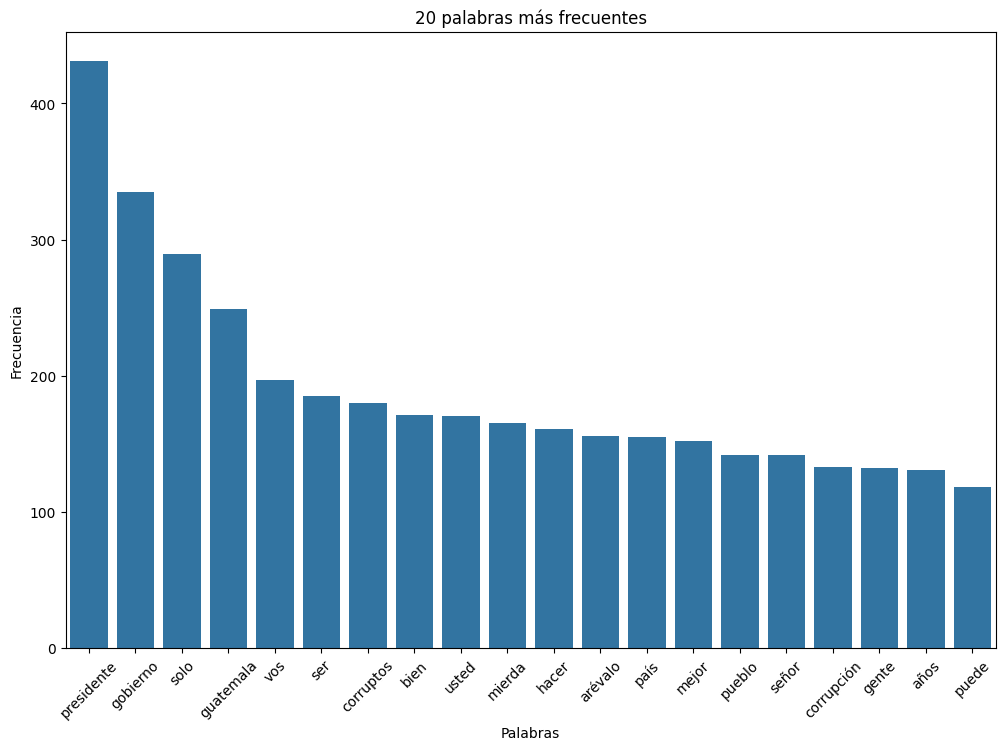

In [6]:
# Número de tweets por día
all_words = ' '.join(df['cleaned_text_no_stopwords']).split()
word_counts = Counter(all_words)
top_words = word_counts.most_common(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=[word[0] for word in top_words], y=[word[1] for word in top_words])
plt.title('20 palabras más frecuentes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

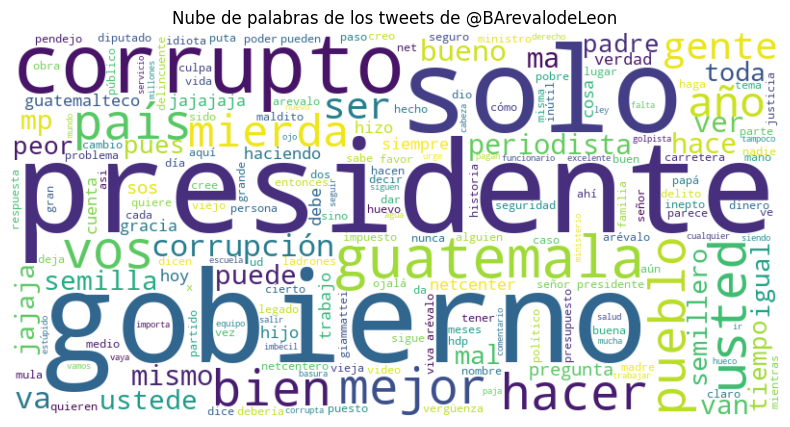

In [7]:
# Nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['cleaned_text_no_stopwords']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de los tweets de @BArevalodeLeon')
plt.show()

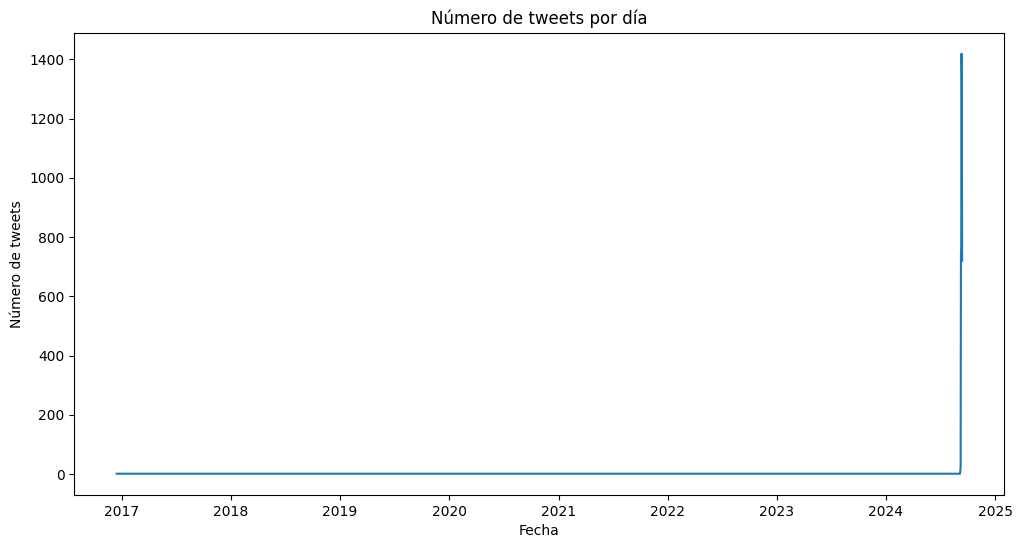

In [8]:
# Número de tweets por día
df['date'] = pd.to_datetime(df['date'])
tweets_por_dia = df.groupby(df['date'].dt.date).size()

plt.figure(figsize=(12, 6))
tweets_por_dia.plot(kind='line')
plt.title('Número de tweets por día')
plt.xlabel('Fecha')
plt.ylabel('Número de tweets')
plt.show()

## Preguntas interesantes

Los temas principales parecen ser: presidente, gobierno, solo, guatemala, vos


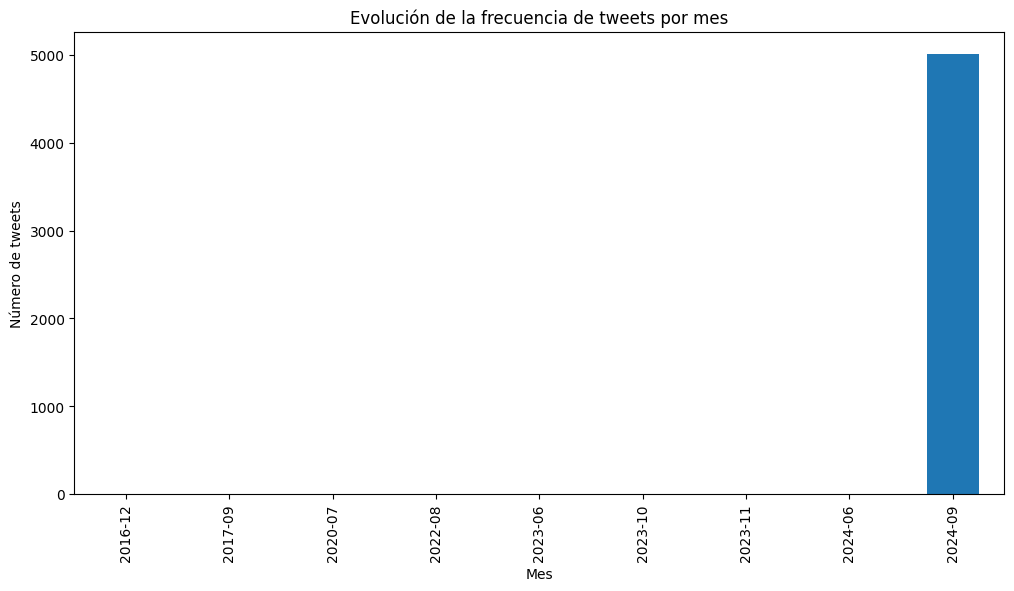

Los 10 hashtags más utilizados son:
urgente: 27
guatemalasaleadelante: 25
minfinsaleadelante: 17
guatemala: 17
presupuesto2025: 14
unpresupuestoparalapoblación: 13
enelpaísdca: 12
nacionalesagn: 8
xelanews: 7
traficogt: 7


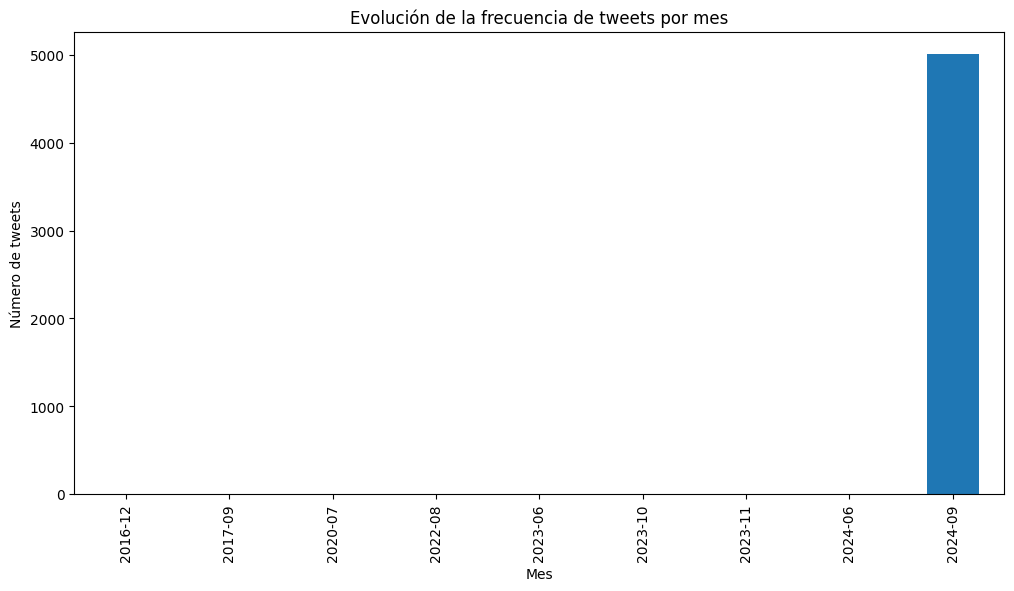

Los 10 hashtags más utilizados son:
urgente: 27
guatemalasaleadelante: 25
minfinsaleadelante: 17
guatemala: 17
presupuesto2025: 14
unpresupuestoparalapoblación: 13
enelpaísdca: 12
nacionalesagn: 8
xelanews: 7
traficogt: 7


In [9]:
# 1. ¿Cuál es el tema principal de los tweets de Bernardo Arévalo?
print("Los temas principales parecen ser:", ", ".join([word[0] for word in top_words[:5]]))

plt.figure(figsize=(12, 6))
df.groupby(df['date'].dt.to_period('M')).size().plot(kind='bar')
plt.title('Evolución de la frecuencia de tweets por mes')
plt.xlabel('Mes')
plt.ylabel('Número de tweets')
plt.show()

hashtags = [tag.lower() for tags in df['hashtags'] for tag in tags if tag.lower() not in stop_words]
top_hashtags = Counter(hashtags).most_common(10)
print("Los 10 hashtags más utilizados son:")
for tag, count in top_hashtags:
    print(f"{tag}: {count}")

# 2. ¿Cómo ha evolucionado la frecuencia de tweets a lo largo del tiempo?
plt.figure(figsize=(12, 6))
df.groupby(df['date'].dt.to_period('M')).size().plot(kind='bar')
plt.title('Evolución de la frecuencia de tweets por mes')
plt.xlabel('Mes')
plt.ylabel('Número de tweets')
plt.show()

# 3. ¿Cuáles son los hashtags más utilizados por Bernardo Arévalo?
print("Los 10 hashtags más utilizados son:")
for tag, count in top_hashtags:
    print(f"{tag}: {count}")

## Análisis de la topología de la red

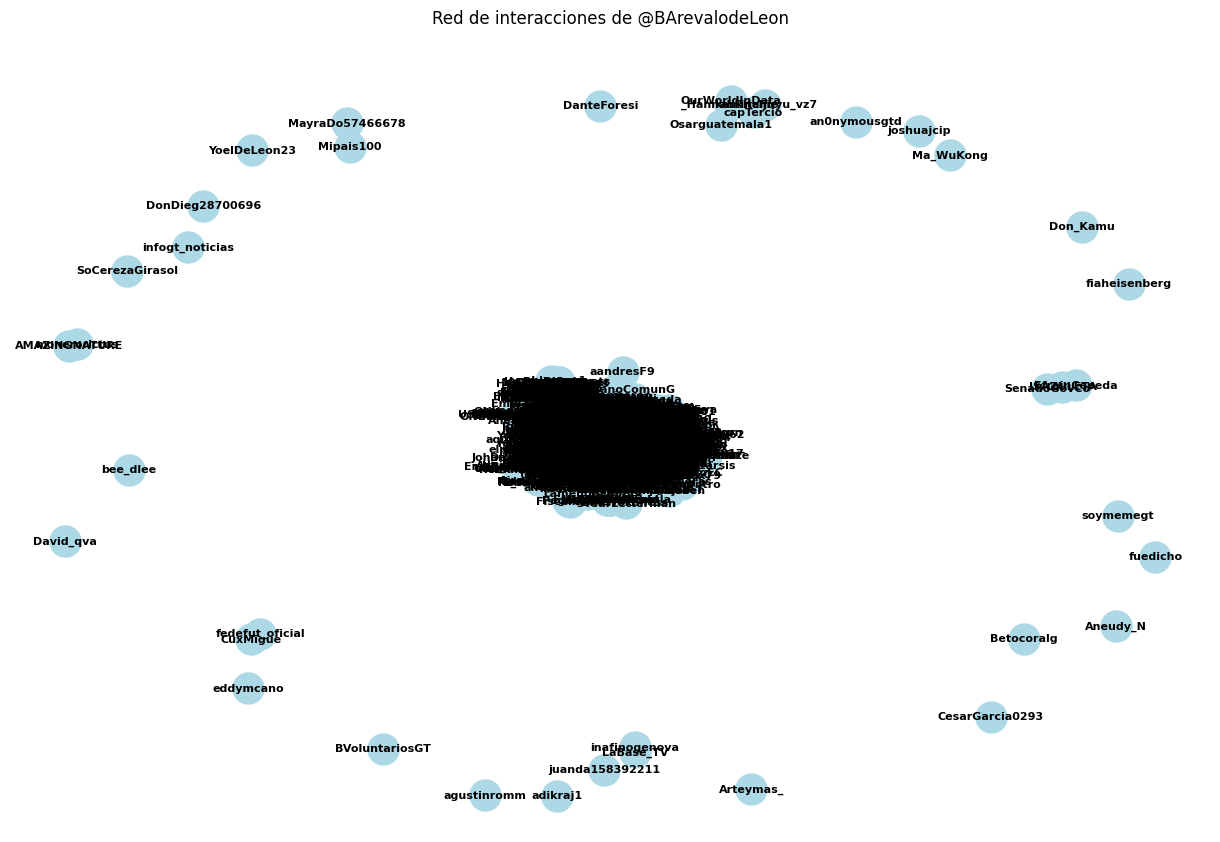

Densidad de la red: 0.002468116847418153
Diámetro de la componente: 6
Diámetro de la componente: 1
Diámetro de la componente: 1
Diámetro de la componente: 1
Diámetro de la componente: 2
Coeficiente de agrupamiento promedio: 0.36941265790477534


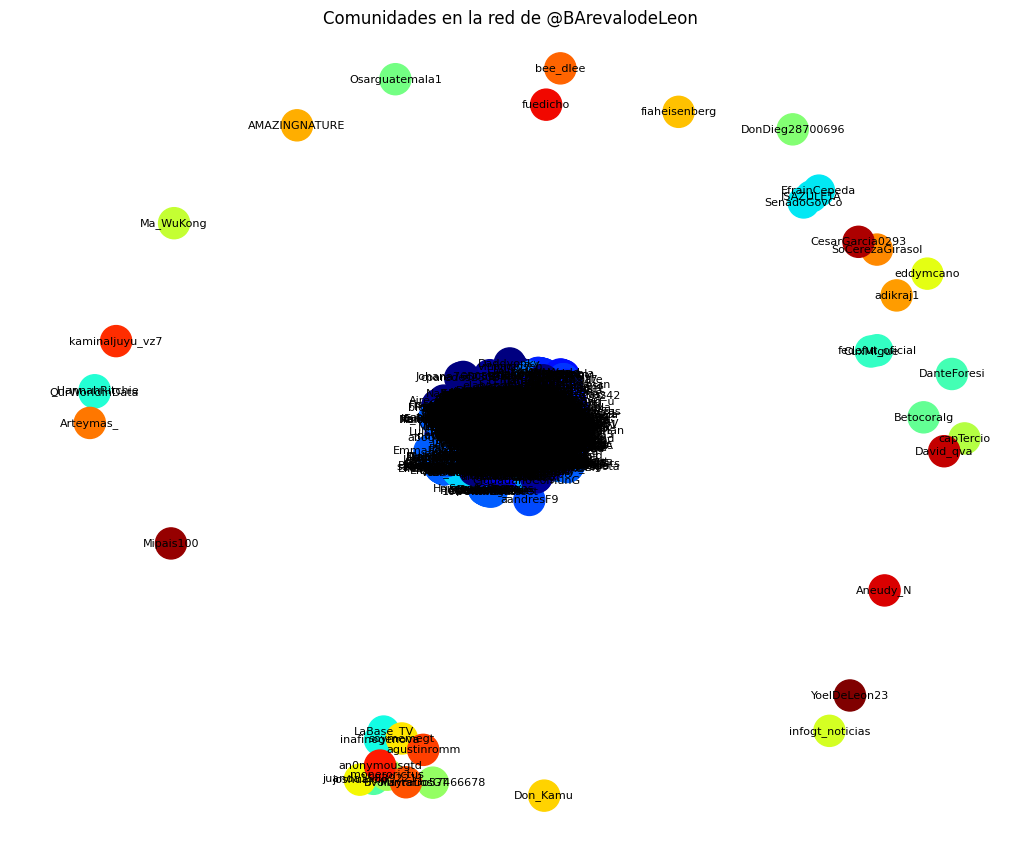

In [10]:
# Crear el grafo
G = nx.Graph()

# Añadir nodos y aristas
for _, row in df.iterrows():
    G.add_node(row['user']['username'])
    for mention in row['mentionedUsers']:
        if mention['username'].lower() not in stop_words:
            G.add_edge(row['user']['username'], mention['username'])

# Dibujar el grafo de interacciones
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=8, font_weight='bold')
plt.title('Red de interacciones de @BArevalodeLeon')
plt.show()

# Calcular y mostrar métricas de la red
print(f"Densidad de la red: {nx.density(G)}")

# Calcular el diámetro solo para componentes conectadas
for component in nx.connected_components(G):
    subgraph = G.subgraph(component)
    if len(subgraph) > 1:  # Asegurarse de que hay más de un nodo
        diameter = nx.diameter(subgraph)
        print(f"Diámetro de la componente: {diameter}")

print(f"Coeficiente de agrupamiento promedio: {nx.average_clustering(G)}")

# Identificación y análisis de comunidades usando cdlib
partition = algorithms.louvain(G)

# Crear un diccionario para los colores de los nodos
node_color = [0] * G.number_of_nodes()  # Inicializa los colores
for community_id, community in enumerate(partition.communities):
    for node in community:
        node_color[list(G.nodes()).index(node)] = community_id  # Asignar un color por comunidad

# Dibujar comunidades en el grafo
pos = nx.spring_layout(G) 
plt.figure(figsize=(10, 8))
nx.draw(G, pos, node_color=node_color, with_labels=True, node_size=500, font_size=8, cmap=plt.cm.jet)
plt.title('Comunidades en la red de @BArevalodeLeon')
plt.show()

In [11]:
## Análisis de influencers y nodos clave

degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top 5 usuarios por centralidad de grado:")
for user, score in top_degree:
    print(f"{user}: {score:.4f}")

print("\nTop 5 usuarios por centralidad de intermediación:")
for user, score in top_betweenness:
    print(f"{user}: {score:.4f}")

print("\nTop 5 usuarios por centralidad de cercanía:")
for user, score in top_closeness:
    print(f"{user}: {score:.4f}")

Top 5 usuarios por centralidad de grado:
BArevalodeLeon: 0.8053
GuatemalaGob: 0.1960
UbaldoMacu: 0.1325
santipalomov: 0.1181
MPguatemala: 0.1072

Top 5 usuarios por centralidad de intermediación:
BArevalodeLeon: 0.8674
GuatemalaGob: 0.0283
ElrevoltijoGT: 0.0183
HPtAmd: 0.0105
FrJuHeAl: 0.0104

Top 5 usuarios por centralidad de cercanía:
BArevalodeLeon: 0.8319
GuatemalaGob: 0.5223
UbaldoMacu: 0.4991
__VaderTG: 0.4788
DiariodeCA: 0.4765


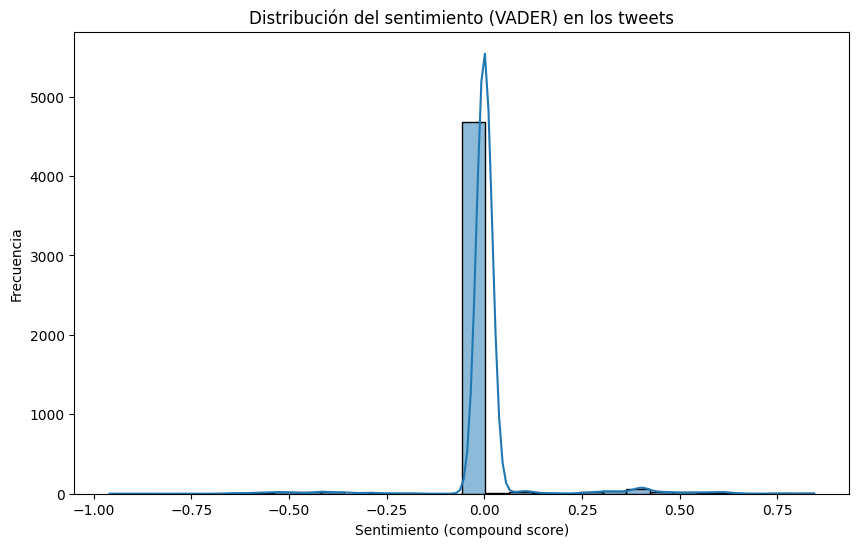

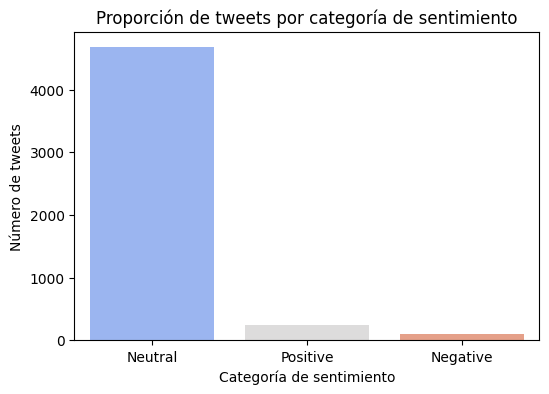

Sentimiento promedio (VADER): 0.01
Neutral     93.245666
Positive     4.702132
Negative     2.052202
Name: sentiment_category, dtype: float64


In [12]:
## Análisis de sentimiento

# Inicializar VADER para el análisis de sentimientos
analyzer = SentimentIntensityAnalyzer()

# Función para obtener el sentimiento
def get_vader_sentiment(text):
    sentiment_score = analyzer.polarity_scores(text)
    return sentiment_score['compound']

# Aplicar el análisis de sentimiento a los tweets
df['vader_sentiment'] = df['cleaned_text_no_stopwords'].apply(get_vader_sentiment)

# Clasificar los tweets como positivos, negativos o neutros
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_category'] = df['vader_sentiment'].apply(categorize_sentiment)

# Visualizar la distribución de los sentimientos
plt.figure(figsize=(10, 6))
sns.histplot(df['vader_sentiment'], kde=True, bins=30)
plt.title('Distribución del sentimiento (VADER) en los tweets')
plt.xlabel('Sentimiento (compound score)')
plt.ylabel('Frecuencia')
plt.show()

# Mostrar proporción de tweets por categoría de sentimiento
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment_category', data=df, palette='coolwarm')
plt.title('Proporción de tweets por categoría de sentimiento')
plt.xlabel('Categoría de sentimiento')
plt.ylabel('Número de tweets')
plt.show()

# Calcular y mostrar el sentimiento promedio
sentimiento_promedio = df['vader_sentiment'].mean()
print(f"Sentimiento promedio (VADER): {sentimiento_promedio:.2f}")

# Mostrar la proporción de tweets en cada categoría
print(df['sentiment_category'].value_counts(normalize=True) * 100)

1. Sentimiento promedio (VADER): 0.01
El sentimiento promedio es prácticamente neutral, con una leve inclinación positiva.

2. Distribución de sentimientos:
- Neutral (93.25%): La mayoría de los tweets son neutros, lo que sugiere que los usuarios expresan poco sentimiento emocional, enfocándose más en hechos.
- Positivo (4.7%): Un pequeño porcentaje de los tweets es positivo, posiblemente relacionado con esfuerzos de ayuda o recuperación.
- Negativo (2.05%): Pocos tweets son negativos, lo que puede indicar que la mayoría de las menciones de desastres son objetivas o informativas.

La conversación en Twitter sobre desastres tiende a ser neutral, con poca carga emocional explícita.

## Conclusiones

### Identificacion de Temas
Los 10 hashtags más utilizados sugieren que los temas recurrentes están centrados en:

- Crisis política y corrupción: Hashtags como #guatemala, #presupuesto2025, y #unpresupuestoparalapoblación reflejan preocupaciones sobre el presupuesto y la gestión pública.
- Movimientos sociales y gobierno: Hashtags como #guatemalasaleadelante y #minfinsaleadelante sugieren movimientos pro-gubernamentales o iniciativas políticas.
- Noticias y cobertura mediática: #nacionalesagn, #xelanews y #enelpaísdca son utilizados por medios de comunicación, lo cual indica que los temas tratados están relacionados con noticias y actualizaciones importantes.

### Interpretación y contexto

- Contextualizacion de los hallazgos:
Los hallazgos muestran que la red está fuertemente centrada alrededor de pocos actores clave, con @BArevalodeLeon como un nodo central tanto en grado como en intermediación y cercanía. Esto significa que tiene una alta influencia sobre el flujo de información dentro de la red.

- Influencia de los influencers
Los influencers como @BArevalodeLeon y @GuatemalaGob son claves en la formación de opiniones públicas debido a su alta centralidad en la red. Pueden influir en cómo se interpretan y discuten temas críticos, como el presupuesto o la corrupción, lo que genera grandes oleadas de interacción, tanto de apoyo como de crítica.

- Comunidades detectadas:
Las comunidades que se organizan alrededor de estos nodos probablemente reflejan grupos con intereses comunes: quienes apoyan al gobierno y su agenda (como la comunidad que usa #guatemalasaleadelante), frente a aquellos que critican decisiones gubernamentales, reflejado en hashtags que denuncian problemas de corrupción.

En resumen, los influencers y las comunidades generan una fuerte polarización en la conversación pública. Los temas recurrentes están alineados con eventos políticos recientes, y el comportamiento de la red refleja un contexto de alto interés social y político, con usuarios concentrados en promover agendas específicas o criticar a figuras clave del gobierno.